## 概览
- 在这个案例中，我们将展示如何通过Paddle Quantum训练量子神经网络来制备量子吉布斯态。

- 首先，让我们通过下面几行代码引入必要的library和package。

In [ ]:
from numpy import array, kron, concatenate, zeros
from numpy import pi as PI
from numpy import trace as nptrace
from paddle import fluid
from paddle.complex import matmul, transpose, trace
from paddle_quantum.circuit import UAnsatz
from paddle_quantum.utils import compute_fid, partial_trace
import scipy

## 背景
量子计算中的前沿方向是量子机器学习和量子优化，在这两个方向，特定量子态的制备是及其重要的问题。特别的，尤其是吉布斯态（Gibbs state）的制备是实现诸多量子算法所必须的一个步骤。
- 给定一个n量子位的哈密顿量H（一般来说这是一个$2^n\times2^n$的厄米矩阵），其在温度$T$下的吉布斯态为$\rho_G {\rm{ = }}\frac{{{e^{ - \beta H}}}}{{tr({e^{ - \beta H}})}}$
- 其中${e^{ - \beta H}}$是矩阵$ - \beta H$的矩阵指数，$\beta  = \frac{1}{{kT}}$是系统的逆温度参数，以及$T$是温度参数，$k$是玻尔兹曼常数(这个例子中我们取为$1$)。

量子计算的诸多应用所需要调用的步骤都依赖于特定哈密顿量的吉布斯态，所以制备出目标哈密顿量的吉布斯态在量子计算和量子机器学习等方向都至关重要，尤其是有着广泛的应用，比如可以用于如下应用中：
- 量子机器学习中受限波尔兹曼机的学习 [1]
- 解决凸优化和半正定规划等优化问题 [2]
- 组合优化问题 [3]

作为一个上手的例子，这里我们首先考虑一个简单的哈密顿量及其吉布斯态。
- 首先我们考虑的是3量子位的哈密顿量，
$H = Z \otimes Z \otimes I + I \otimes Z \otimes Z + Z \otimes I \otimes Z$,  
其中
$$
I=\left [
\begin{matrix}
1 & 0  \\
0 & 1  \\
\end{matrix} 
\right ], \quad 
Z=\left [
\begin{matrix}
1 & 0  \\
0 & -1  \\
\end{matrix} 
\right ].
$$

- 这个例子中，我们将逆温度参数设置为$\beta = 1.5$。

- 此外，为了方便测试结果，我们利用定义提前生成好了理想情况的吉布斯态。

In [ ]:
beta = 1.5

sigma_I = array([[1, 0], [0, 1]])
sigma_Z = array([[1, 0], [0, -1]])
hamiltonian = (-kron(kron(sigma_Z, sigma_Z), sigma_I) - kron(kron(sigma_I, sigma_Z), sigma_Z) - kron(kron(sigma_Z, sigma_I), sigma_Z))
rho = scipy.linalg.expm(-1 * beta * hamiltonian) / nptrace(scipy.linalg.expm(-1 * beta * hamiltonian))
hamiltonian = hamiltonian.astype("complex64")
rho = rho.astype("complex64")

## 搭建量子神经网络
- 在这个案例中，我们将通过训练量子神经网络QNN（也可以理解为参数化量子电路）来训练吉布斯态。这里，我们提供一个简单的4量子位的量子电路如下：
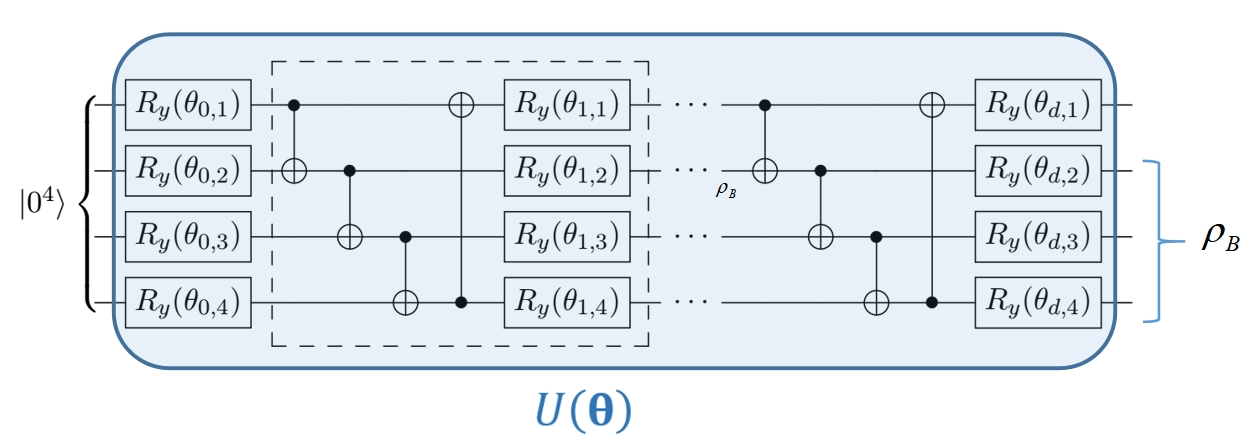

- 我们预设一些该参数化电路的参数，比如宽度为4量子位，其中第1个量子位是辅助系统，第2-4个量子位是最后产生吉布斯态的系统。

- 初始化其中的变量参数，${\bf{\theta }}$代表我们量子神经网络中的参数组成的向量。
         

In [ ]:
N = 4 #量子神经网络的宽度
N_SYS_B = 3 #生成吉布斯态的系统B的量子位数   
D = 1 #量子神经网络中重复模块的深度，这里只用1层
SEED = 1 #种子

- 接下来我们根据上图中的电路设计，具体通过PaddleQuantum的UAnsatz函数来搭建量子神经网络。      

In [ ]:
def U_theta(theta, input_state, N, D):
    """
    Circuit
    """

    cir = UAnsatz(N, input_state=input_state)
    for i in range(N):
        cir.ry(theta=theta[0][1][i], which_qubit=i + 1)
        
    for repeat in range(D):
        for i in range(1, N):
            cir.cnot(control=[i, i + 1])
         
        for i in range(N):
            cir.ry(theta=theta[repeat][0][i], which_qubit=i + 1)
    return cir.state


## 配置训练模型 - 损失函数
- 现在我们已经有了数据和量子神经网络的架构，我们将进一步定义合适的训练参数、模型和损失函数来达到我们的目标。
- 具体的我们参考的是[4]中的方法（核心思想是利用吉布斯态达到了最小自由能的性质）。
- 通过作用量子神经网络$U(\theta)$在初始态上，我们可以得到输出态$\left| {\psi \left( {\bf{\theta }} \right)} \right\rangle $, 其在第2-4个量子位的态记为$\rho_B(\theta)$.
- 设置训练模型中的的损失函数，在吉布斯态学习中，我们利用冯诺依曼熵函数的截断来进行自由能的估计，相应的损失函数参考[4]可以设为 
$loss= {L_1} + {L_2} + {L_3}$，其中${L_1} = tr(H\rho_B)$, ${L_2} = 2{\beta ^{ - 1}}{\mathop{\rm Tr}\nolimits} \left( \rho_B^2 \right)$, $- {\beta ^{ - 1}}\frac{{Tr(\rho_B^3) + 3}}{2}$.

In [ ]:
class Net(fluid.dygraph.Layer):
    """
    Construct the model net
    """

    def __init__(self, shape, param_attr=fluid.initializer.Uniform(low=0.0, high=PI, seed=SEED),
                 dtype='float32'):
        super(Net, self).__init__()

        self.theta = self.create_parameter(shape=shape, attr=param_attr, dtype=dtype, is_bias=False)

    def forward(self, input_state, H, N, N_SYS_B, D):
        """
        Args:
            input_state: The initial state with default |0..>
            H: The target Hamiltonian
        Returns:
            The loss.
        """

        out_state = U_theta(self.theta, input_state, N, D)

        # rho_AB = utils.matmul(utils.matrix_conjugate_transpose(out_state), out_state)
        rho_AB = matmul(transpose(
            fluid.framework.ComplexVariable(out_state.real, -out_state.imag), perm=[1, 0]), out_state)

        # compute the partial trace and three losses
        rho_B = partial_trace(rho_AB, 2 ** (N - N_SYS_B), 2 ** (N_SYS_B), 1)
        rho_B_squre = matmul(rho_B, rho_B)
        loss1 = (trace(matmul(rho_B, H))).real
        loss2 = (trace(rho_B_squre)).real * 2
        loss3 = - (trace(matmul(rho_B_squre, rho_B))).real / 2

        loss = loss1 + loss2 + loss3  # 损失函数

        # option: if you want to check whether the imaginary part is 0, uncomment the following
        # print('loss_iminary_part: ', loss.numpy()[1])
        return loss - 3 / 2, rho_B

## 配置训练模型 - 模型参数
在进行量子神经网络的训练之前，我们还需要进行一些训练（超）参数的设置，例如学习速率与迭代次数。
- 设定学习速率（learning rate）为0.5, 迭代次数为50次。

In [ ]:
ITR = 50 #训练的总的迭代次数

LR = 0.5 #学习速率

## 进行训练

- 当训练模型的各项参数都设置完成后，我们将数据转化为Paddle动态图中的变量，进而进行量子神经网络的训练。
- 训练过程中我们用的是[Adam Optimizer](https://www.paddlepaddle.org.cn/documentation/docs/zh/api_cn/optimizer_cn/AdagradOptimizer_cn.html)，也可以调用Paddle中提供的其他优化器。
- 我们将训练过程中的结果依次输出。
- 特别的我们依次输出了我们学习到的量子态$\rho_B(\theta)$与吉布斯态$\rho_G$的保真度，保真度越高说明QNN输出的态越接近于吉布斯态。


In [ ]:
with fluid.dygraph.guard():
    # initial state preparing
    _initial_state_np = concatenate(([[1.]], zeros([1, 2 ** N - 1])), axis=1).astype('complex64')
    initial_state = fluid.dygraph.to_variable(_initial_state_np)

    # gibbs Hamiltonian preparing
    H = fluid.dygraph.to_variable(hamiltonian)

    # net
    net = Net(shape=[D + 1, 3, N])

    # optimizer
    opt = fluid.optimizer.AdamOptimizer(learning_rate=LR, parameter_list=net.parameters())

    # gradient descent loop
    for itr in range(1, ITR + 1):
        loss, rho_B = net(initial_state, H, N, N_SYS_B, D)

        loss.backward()
        opt.minimize(loss)
        net.clear_gradients()

        rho_B = rho_B.numpy()

        fid = compute_fid(rho_B, rho)
        print('iter:', itr, 'loss:', '%.4f' % loss.numpy(), 'fid:', '%.4f' % fid)


## 总结
根据上面训练得到的结果，通过大概50次迭代，我们就能达到高于99.5%保真度的高精度吉布斯态，高效并精确地完成了吉布斯态的制备。我们可以通过print函数来输出学习到的量子神经网络的参数和它的输出态。

### 参考文献

[1] M. Kieferová and N. Wiebe, “Tomography and generative training with quantum Boltzmann machines,” Phys. Rev. A, vol. 96, no. 6, p. 062327, Dec. 2017.

[2] F. G. S. L. Brandao and K. M. Svore, “Quantum Speed-Ups for Solving Semidefinite Programs,” in 2017 IEEE 58th Annual Symposium on Foundations of Computer Science (FOCS), 2017, pp. 415–426.

[3] R. D. Somma, S. Boixo, H. Barnum, and E. Knill, “Quantum Simulations of Classical Annealing Processes,” Phys. Rev. Lett., vol. 101, no. 13, p. 130504, Sep. 2008.

[4] Y. Wang, G. Li, and X. Wang, “Variational quantum Gibbs state preparation with a truncated Taylor series,” arXiv:2005.08797, May 2020. [[pdf](https://arxiv.org/pdf/2005.08797.pdf)]